In [ ]:
!pip install langdetect
!pip install transformers
!pip install wordcloud matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
import numpy as np
import string, pprint
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import defaultdict
import spacy
import re
from langdetect import detect
from collections import defaultdict
from nltk.corpus import wordnet
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from textblob import TextBlob
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('sentiwordnet')
import warnings
warnings.filterwarnings("ignore", message="Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
full_df = pd.read_csv('/content/drive/MyDrive/dataset/hotels.csv')

In [ ]:
df = full_df.groupby('hotel')['review'].apply(lambda x: '\n'.join(x)).reset_index()

In [ ]:
hotel_1= df.iloc[0]

In [ ]:
def prep_rev(sent):
  sent= sent.replace('\t', '. ').replace('&amp', '').replace('quot', '')
  sent= re.sub(r'[^a-zA-Z0-9\s\'\"?!,;:().]', '', sent)
  return sent

In [ ]:
pre_reviews= hotel_1['review'].split('\n')
reviews= [prep_rev(x) for x in pre_reviews]

In [ ]:
def summarize_hotel_reviews(reviews, num_sentences):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    #Tokenize and encode
    review_tokens = tokenizer.batch_encode_plus(
        reviews,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    #Extract sentence embeddings using BERT
    with torch.no_grad():
        review_outputs = model(
            review_tokens['input_ids'],
            attention_mask=review_tokens['attention_mask']
        )[0]

    #Calculate sentence importance
    review_embeddings = torch.mean(review_outputs, dim=1)

    #Rank sentences based on cosine similarity
    similarity_matrix = cosine_similarity(review_embeddings)
    np.fill_diagonal(similarity_matrix, 0)
    sentence_scores = similarity_matrix.sum(axis=1)

    #Select top sentences
    top_sentence_indices = sentence_scores.argsort()[-num_sentences:][::-1]

    summary = ""
    for index in top_sentence_indices:
        summary += reviews[index] + ". "

    return summary

In [ ]:
num_sentences = 80

#reviews= hotel_1['review'].split('\n')
summary = summarize_hotel_reviews(reviews, num_sentences)

print("\n\nTOP 80 reviews\n")
print(summary)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




TOP 10 reviews

Fantastic beautiful desert magic. The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!) an individual infinity pool looking over the desert  gazelles wandering past...heaven. We took a moonlit jeep safari to our own private desert dinner under the stars  this place is magical. The reception service was a little slow, but once we were fully checked in, we relaxed totally into a fantastic stay. The pool and spa were also wonderful, and the restaurant was really good. I think our weekend was long enough to enjoy the desert activities and to properly relax. It is expensive, but worth it, and ideal for a short break from Dubai. You are totally secluded from other guests and get a wonderful sense of the wonders of arabia  shame they don't allow children under 12 because i am sure children would love seeing all the desert animals as

In [ ]:
sentences = nltk.sent_tokenize(summary)
print(sentences)

['Fantastic beautiful desert magic.', "The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!)", 'an individual infinity pool looking over the desert  gazelles wandering past...heaven.', 'We took a moonlit jeep safari to our own private desert dinner under the stars  this place is magical.', 'The reception service was a little slow, but once we were fully checked in, we relaxed totally into a fantastic stay.', 'The pool and spa were also wonderful, and the restaurant was really good.', 'I think our weekend was long enough to enjoy the desert activities and to properly relax.', 'It is expensive, but worth it, and ideal for a short break from Dubai.', "You are totally secluded from other guests and get a wonderful sense of the wonders of arabia  shame they don't allow children under 12 because i am sure children would love seeing all the desert an

In [ ]:
aspects = ['room', 'staff', 'place', 'food']

# Create an empty dictionary to store the aspect-synonym mappings
aspect_synonyms = {}

# Loop through each aspect in the original list
for aspect in aspects:
    # Create a set to store the synonyms of the aspect
    synonyms = set()
    # Get the synonyms of the aspect using WordNet
    for syn in wordnet.synsets(aspect):
        for lemma in syn.lemmas():
            # Add the synonym to the set
            synonyms.add(lemma.name().replace('_', ' ').lower())
    # Add the aspect and its synonyms to the dictionary
    aspect_synonyms[aspect] = synonyms

# Define TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Generate TF-IDF matrix for sentences
tfidf_matrix = vectorizer.fit_transform(sentences)

# Generate K-Means clusters
kmeans = KMeans(n_clusters=len(aspects), random_state=0).fit(tfidf_matrix)

# Group sentences into clusters
groups = [[] for i in range(len(aspects))]
for i in range(len(sentences)):
    aspect = None
    for j, word in enumerate(sentences[i].split()):
        for a, syns in aspect_synonyms.items():
            if word in syns:
                aspect = a
                break
        if aspect is not None:
            break
    if aspect is not None:
        groups[aspects.index(aspect)].append(sentences[i])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
aspect_Sentences = {}

for i, group in enumerate(groups):
    if len(group) > 0:
        #print(f"Group of sentences about aspect '{aspects[i]}':\n")
        aspect={}
        t = '\n'.join(group)
        aspect['sentence'] = t
        print(aspect)
        aspect_Sentences[aspects[i]] = aspect
        print('\n')

{'sentence': "The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!)\ninstead we ate almost all our meals in our room (at no extra charge!)\nMet with breakfast cocktails and an apology for our room not being ready!\nThere isn't really a lot to see in the desert that isn't already in the grounds, (oryx etc), but the sundowner camel ride and the falconery are good.The best part is obviously the room and pool.\nHowvever the dune driving is a great experince!We took full advantage of the room service having our lunch bought to us each day and indulging in private dining on our decking.\nBest of all would be when you come back to your room and could enjoy the pool in privacy.\nAfter we had a sleep my husband decided that he did not like this room as it did not have a view of the watering hole, where most of the wildlife congregates, it was no proble

In [ ]:
aspect_Sentences

{'room': {'sentence': "The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!)\ninstead we ate almost all our meals in our room (at no extra charge!)\nMet with breakfast cocktails and an apology for our room not being ready!\nThere isn't really a lot to see in the desert that isn't already in the grounds, (oryx etc), but the sundowner camel ride and the falconery are good.The best part is obviously the room and pool.\nHowvever the dune driving is a great experince!We took full advantage of the room service having our lunch bought to us each day and indulging in private dining on our decking.\nBest of all would be when you come back to your room and could enjoy the pool in privacy.\nAfter we had a sleep my husband decided that he did not like this room as it did not have a view of the watering hole, where most of the wildlife congregates, it was 

In [ ]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
for key,values in aspect_Sentences.items():
  v = values['sentence']
  sentences = nltk.sent_tokenize(v)
  #print(sentences)
  positive_opinions = []
  negative_opinions = []
  neutral_opinions = []
  for sentence in sentences:
    sentiment_score = sid.polarity_scores(sentence)['compound']
    blob = TextBlob(sentence)
    sentiment_score = blob.sentiment.polarity
    #print(sentiment_score)
    if sentiment_score > 0.1:
        positive_opinions.append(sentence)
        print(sentiment_score,sentence)
    elif sentiment_score < 0:
        negative_opinions.append(sentence)
        print(sentiment_score,sentence)
    else:
        neutral_opinions.append(sentence)
        print(sentiment_score,sentence)
      
  #if(len(positive_opinions)!=0):
  aspect_Sentences[key]['pos_opion'] = positive_opinions
  #if(len(negative_opinions)!=0):
  aspect_Sentences[key]['neg_opion'] = negative_opinions 
  #if(len(neutral_opinions)!=0):
  aspect_Sentences[key]['neu_opion'] = neutral_opinions

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0.5833333333333334 The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!)
0.0 instead we ate almost all our meals in our room (at no extra charge!)
0.25 Met with breakfast cocktails and an apology for our room not being ready!
0.39999999999999997 There isn't really a lot to see in the desert that isn't already in the grounds, (oryx etc), but the sundowner camel ride and the falconery are good.The best part is obviously the room and pool.
0.3833333333333333 Howvever the dune driving is a great experince!We took full advantage of the room service having our lunch bought to us each day and indulging in private dining on our decking.
0.4666666666666666 Best of all would be when you come back to your room and could enjoy the pool in privacy.
0.06901041666666667 After we had a sleep my husband decided that he did not like this room as it did not have

In [ ]:
pos= []
pos.append(aspect_Sentences['room']['pos_opion'])
pos.append(aspect_Sentences['place']['pos_opion'])
pos.append(aspect_Sentences['staff']['pos_opion'])
pos.append(aspect_Sentences['food']['pos_opion'])

neg= []
neg.append(aspect_Sentences['room']['neg_opion'])
neg.append(aspect_Sentences['place']['neg_opion'])
neg.append(aspect_Sentences['staff']['neg_opion'])
neg.append(aspect_Sentences['food']['neg_opion'])

neu= []
neu.append(aspect_Sentences['room']['neu_opion'])
neu.append(aspect_Sentences['place']['neu_opion'])
neu.append(aspect_Sentences['staff']['neu_opion'])
neu.append(aspect_Sentences['food']['neu_opion'])

print(len(aspects))
print(len(pos))
print(len(neg))
print(len(neu))
df=pd.DataFrame({'aspect':aspects,'positive':pos,'negative':neg,'neutral':neu})

4
4
4
4


In [ ]:
df

,aspect,positive,negative,neutral
0,room,[The rooms at Al Maha are like nothing I've ex...,[There are other desert hotels in Dubai but Al...,[instead we ate almost all our meals in our ro...
1,staff,[We took a moonlit jeep safari to our own priv...,[It was about 45 degrees celsius in the middel...,[We didn't feel at all out of place and didn't...
2,place,"[Al Maha is a simply stunning location, the st...",[The staff in the restaurant were also extreme...,[The King actually has a private suite here!It...
3,food,[the food was better than the burj and we even...,[anyone know of any other resort similiar to t...,[The spapool area was exellent as well as the ...


In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Final_code/sentiment_opinions.csv")

In [ ]:
def get_wordnet_pos(treebank_tag):
   if treebank_tag.startswith('J'):
       return wn.ADJ
   elif treebank_tag.startswith('V'):
       return wn.VERB
   elif treebank_tag.startswith('N'):
       return wn.NOUN
   elif treebank_tag.startswith('R'):
       return wn.ADV
   else:
       return None

The rooms at Al Maha are like nothing I've experienced before, with your own bedouin style interior, huge beds, exotic bathrooms (and fab mod cons  including the world's best in room coffee makers!)
Met with breakfast cocktails and an apology for our room not being ready!
There isn't really a lot to see in the desert that isn't already in the grounds, (oryx etc), but the sundowner camel ride and the falconery are good.The best part is obviously the room and pool.
Howvever the dune driving is a great experince!We took full advantage of the room service having our lunch bought to us each day and indulging in private dining on our decking.
Best of all would be when you come back to your room and could enjoy the pool in privacy.
The room and Arabian dcor evoked a romance and tranquility straight out of a novel.
The private pool is sizeable and the bedroom and bathroom is massive.There is a restaurant but we ate most of our meals in our room and I would definitley recommend for an extra 100

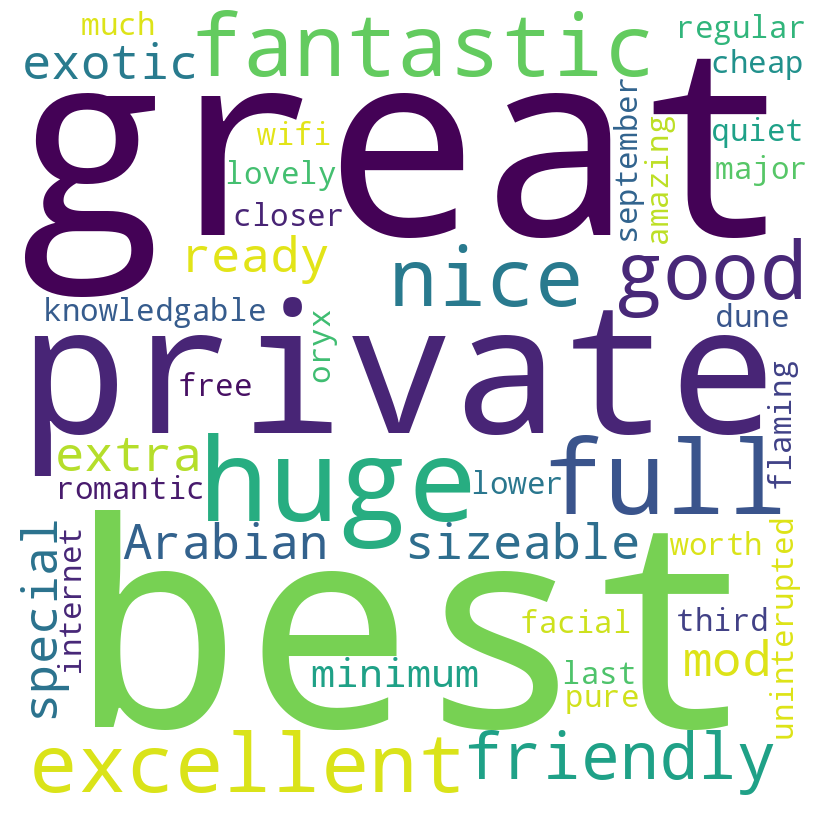

In [ ]:
#positive_room
positive_adj = []
for sentence in df.iloc[0]['positive']:
  #sentence = sen[i]
  print(sentence)
  #print(type(sentence))
  tokens = nltk.word_tokenize(sentence)
  pos_tags = nltk.pos_tag(tokens)

  
  for word, tag in pos_tags:
    pos = get_wordnet_pos(tag)
    if pos == wn.ADJ:
        positive_adj.append(word)

positive_adj_text = " ".join(positive_adj)
wordcloud = WordCloud(width=800, height=800, background_color="white", collocations=False).generate(positive_adj_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

There are other desert hotels in Dubai but Al Maha stands way above the competition.
Lounging in the pool and looking out at this scene never got boring, it was a total disconnect from the hustle and bustle.You can eat on the deck of your pool for lunch dinner and breakfast if you wish (all included in room rate).
We are returning August 2006 on our way back from the far east and know we will not be disappointed.. Out Of This World.
only 2 minor faults  they didn't tell us that the restuarant has a dress code for dinner so we had to go bak to our room and change which was very inconvenient.
A sprinkling of some local faces would go a long way to further delivering the 'real desert' expereince.And finally, despite the claims of 'widllifewatching', our activity on the last day gave sight to only a few gazelles and Oryx...which was ironcially upstaged by the trip home!On a postive note however, you do get to completly unwind and relax.
We'd requested a quiet room in advance, and were allo

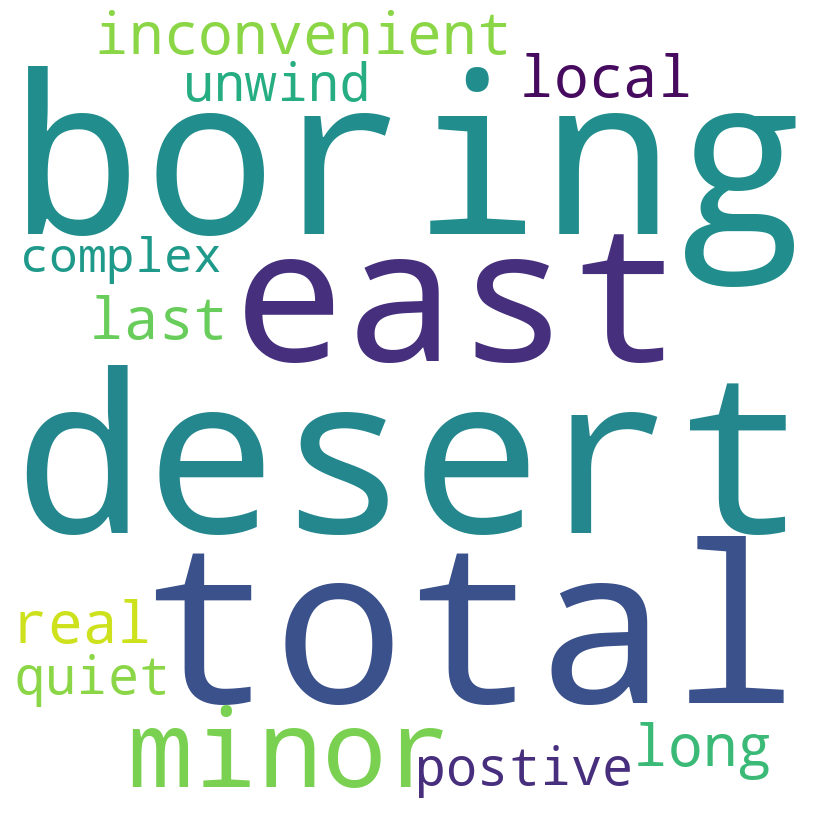

In [ ]:
#negative_room
negative_adj = []
for sentence in df.iloc[0]['negative']:
  #sentence = sen[i]
  print(sentence)
  #print(type(sentence))
  tokens = nltk.word_tokenize(sentence)
  pos_tags = nltk.pos_tag(tokens)

  
  for word, tag in pos_tags:
    pos = get_wordnet_pos(tag)
    if pos == wn.ADJ:
        negative_adj.append(word)

negative_adj_text = " ".join(negative_adj)
wordcloud = WordCloud(width=800, height=800, background_color="white", collocations=False).generate(negative_adj_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We took a moonlit jeep safari to our own private desert dinner under the stars  this place is magical.
wonderful place in the desert.
The most relaxing place ever.
Our guide told us that it is the single biggest property in the UAE and takes up something incredible like 20 of the land mass of Dubai.Anyhow, from the moment you arrive in reception, to the moment you leave, you will be treated like royalty.
Had a fun time on the camel ride watching the sun set and sip champagne.
The resort is set in a conservation area and it is 9km drive from the main gates.
Set in a nature reserve and home to protected species, the Al Maha is one of the hotels where you would pay the money for the experience.From the morning horse rides and 4x4 dune racing to the evening activities of falconry and sunset camel treks.Set in a breathtaking location, each 'tent' had its own private pool.
This was the most relaxing place we have ever stayed .
We could easily have flown straight home and still considered tha

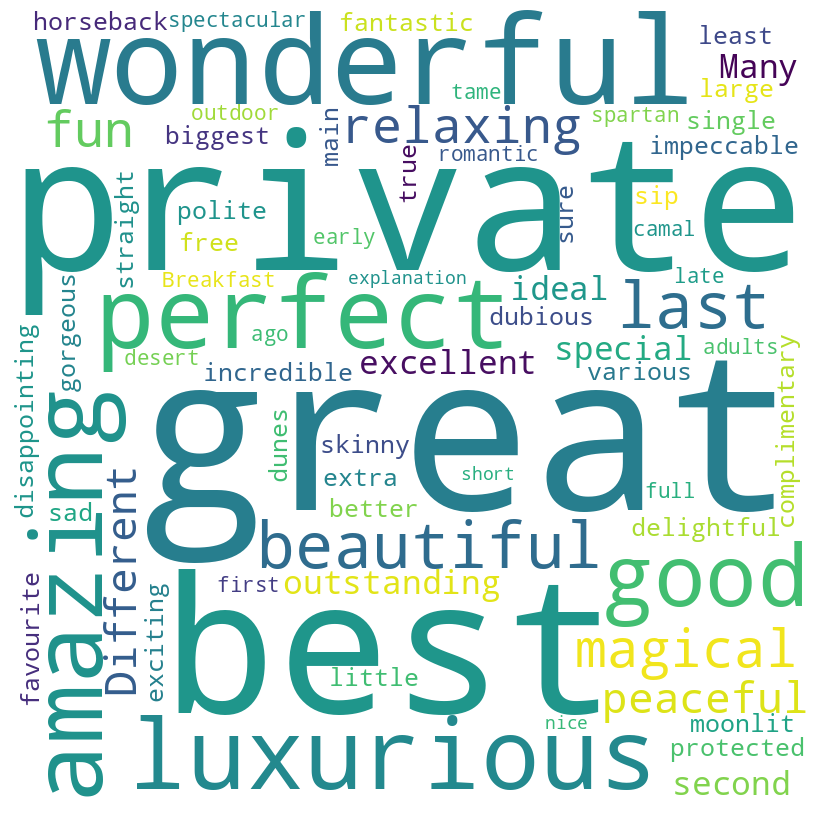

In [ ]:
#positive_staff
positive_adj = []
for sentence in df.iloc[1]['positive']:
  #sentence = sen[i]
  print(sentence)
  #print(type(sentence))
  tokens = nltk.word_tokenize(sentence)
  pos_tags = nltk.pos_tag(tokens)

  
  for word, tag in pos_tags:
    pos = get_wordnet_pos(tag)
    if pos == wn.ADJ:
        positive_adj.append(word)

positive_adj_text = " ".join(positive_adj)
wordcloud = WordCloud(width=800, height=800, background_color="white", collocations=False).generate(positive_adj_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

It was about 45 degrees celsius in the middel of the day so all the activities took place in the early morning or in the late afternoon.
My only gripe about the suite was the stupid place in which the TV in the bedroom was located which meant that without moving the furniture around you could only watch it by lying on the bed.
If i have to fault this place it would be on the restaurant food, not a great choice and definately not a 5 restaurant, shame it let it down, as everything else was definately 5.
The so called game drives are only about 1 hour and you will be seated with 4 (3 at the back seat, so with 1 middle seat !
;This is THE place for a dirty weekend; a friend urged when he persuaded me to go to Al Maha.
The standard of service is what sets this place apart from other desert resorts which attempt to emulate the same experience.


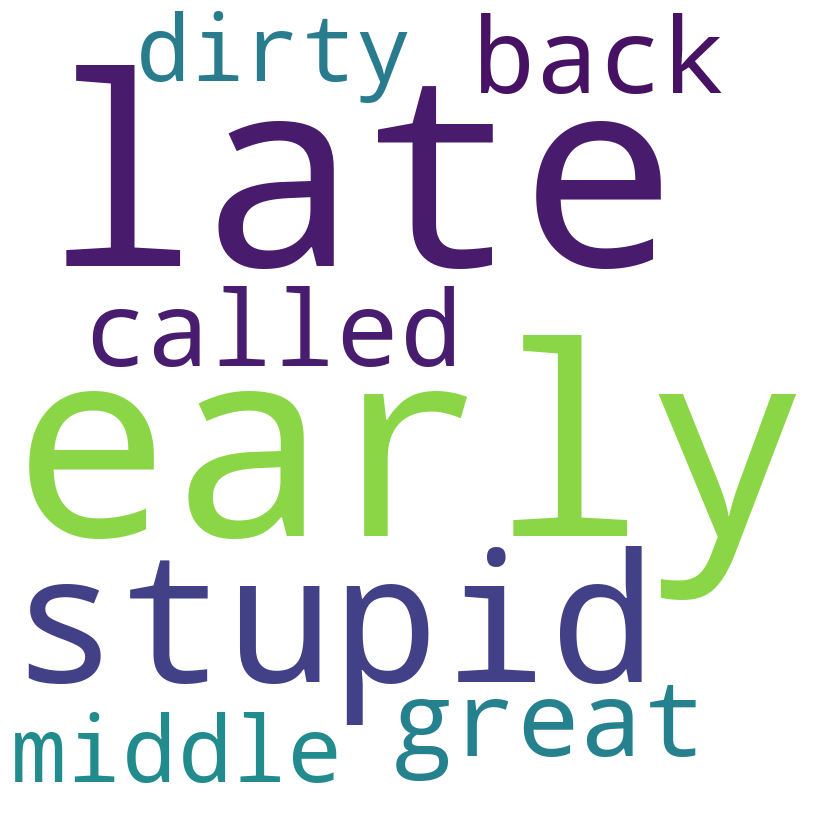

In [ ]:
#negative_staff
negative_adj = []
for sentence in df.iloc[1]['negative']:
  #sentence = sen[i]
  print(sentence)
  #print(type(sentence))
  tokens = nltk.word_tokenize(sentence)
  pos_tags = nltk.pos_tag(tokens)

  
  for word, tag in pos_tags:
    pos = get_wordnet_pos(tag)
    if pos == wn.ADJ:
        negative_adj.append(word)

negative_adj_text = " ".join(negative_adj)
wordcloud = WordCloud(width=800, height=800, background_color="white", collocations=False).generate(negative_adj_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Al Maha is a simply stunning location, the staff are fantastic, and I immediately felt totally relaxed from the moment I arrived.
Unlike the rest of Dubai, the staff seem genuinely happy to work there and hopefully they are being looked after in return.
Meals were good and the serving staff very friendly.
All the staff were very friendly and helpful.
We had 3 very good waiting staff  Mahinda, Joey and Jovy who catered for our every whim.
All staff are so helpful and kind  nothing is too much bother.
All the staff were very attentive to our every wish throughout our stay without being intrusive.
The rooms and pool were our favourite part, but the food, staff and general ambience were all first class.
there are many excellent hotels around the world but AL MAHA is not only a luxury resort it is one of the most romantic and unique places I have ever been.the conservation area is beautiful , the desert amazing and the service and friendlyness of the staff is unsurpassed.
The staff are impe

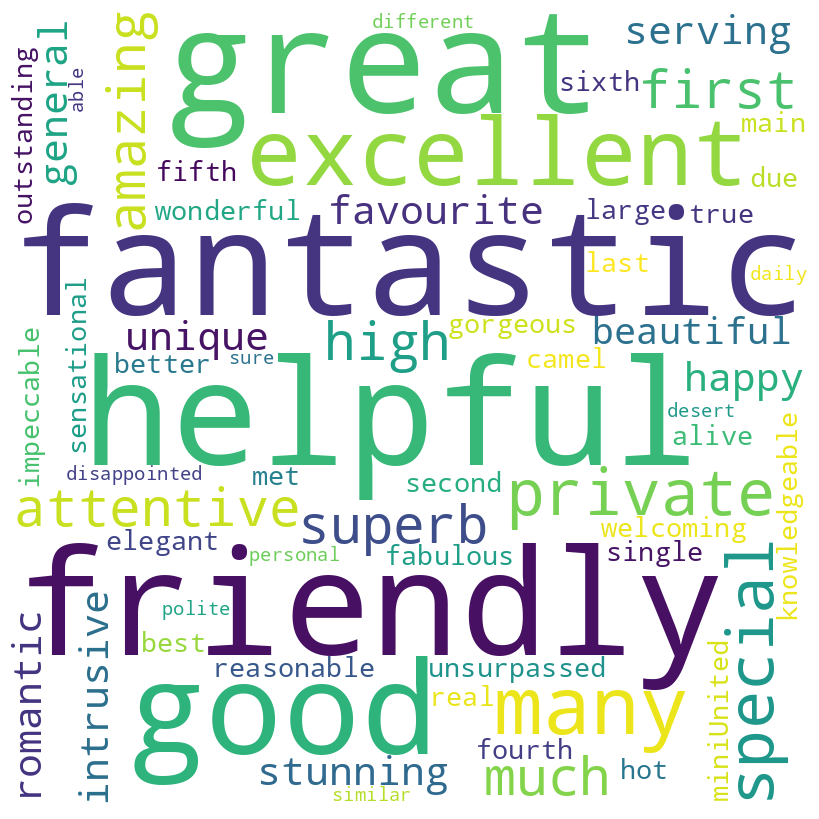

In [ ]:
#positive_place
positive_adj = []
for sentence in df.iloc[2]['positive']:
  #sentence = sen[i]
  print(sentence)
  #print(type(sentence))
  tokens = nltk.word_tokenize(sentence)
  pos_tags = nltk.pos_tag(tokens)

  
  for word, tag in pos_tags:
    pos = get_wordnet_pos(tag)
    if pos == wn.ADJ:
        positive_adj.append(word)

positive_adj_text = " ".join(positive_adj)
wordcloud = WordCloud(width=800, height=800, background_color="white", collocations=False).generate(positive_adj_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()